# Solving Travelling Salesman Problem with Genetic, Bee and Ant Algorithms

Genetic Algorithm Source: "Hands-On Genetic Algorithms with Python" by Eyal Wirsansky. Packt Publishing. 2020.

## Travelling Salesman Problem
Imagine that you manage a small fulfillment center and need to deliver packages to a list of customers using a single vehicle. What is the best route for the vehicle to take so that you visit all your customers and then return to the starting point? This is an example of the classic Travelling Salesman Problem (TSP).

The TSP dates back to 1930 and since then has been and is one of the most throughly studied problems in optimization. It is often used to benchmark optimization algorithms. The problem has many variants, but it was originally based on a traveling salesman that needs to take a trip covering several cities:

_Given a list of cities and the distances between each pair of the cities, find the shortest possibile path that goes through all the cities, and returns to the starting city._

Using combinatorics, you could find that when given $n$ cities, the number of possible paths that go through all cities is $\frac{(n-1)!}{2}$

The following screenshot represents the shortest path for the traveling salesperson problem that covers the 15 largest cities in Germany.

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c4/TSP_Deutschland_3.png">

As in this case $n=15$, the number of possible routes is $\frac{14!}{2}$, which calculates to the staggering number of $43589145600$

In the context of search algorithms, each part (or partial path) through the cities represents a state, and the set of all possible paths is considered the state space. Each of the paths has a corresponding cost - the lenght (distance) of the path - and we are looking for the path that will minimize this distance.

## TSPLIB Benchmark Files
TSPLIB is a library containing sample problems for the TSP based on actual geographic locations of cities. The library is maintained by the Heidelberg University, and relevant examples can be found [here](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/). The optimal distances for each problem can be found [here](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/STSP.html).

The TSPLIB examples are contained in text-based, whitespace-delimited data files. A typical file contains several informational lines followed by the city data. We are interested in files that contain the x, y coordinates of the participating cities, so we can plot the cities and visualize their locations.

In [58]:
import os
import pickle
import csv
import gzip
from io import StringIO
from urllib.request import urlopen, Request
import seaborn as sns
import matplotlib.pyplot as plt
from array import array
import random
import numpy as np
from deap import base, creator, tools
from tabulate import tabulate
from time import time
from sys import getsizeof

Change the following cell to pick up a different dataset.

In [59]:
name = 'bayg29'

Search for the selected dataset in the file system first.

In [60]:
locations = []
distances = []

In [61]:
try:
    locations = pickle.load(open(os.path.join("tsp-data", name + "-loc.pickle"), "rb"))
    distances = pickle.load(open(os.path.join("tsp-data", name + "-dist.pickle"), "rb"))
except (OSError, IOError):
    pass

If the serialized data was not found, then download it from Internet.

In [62]:
def download_dataset(url: str) -> str:
    request = Request(url)
    request.add_header('Accept-Encoding', 'gzip')
    response = urlopen(request)
    return gzip.decompress(response.read()).decode()

In [63]:
def parse(content: str) -> list:
    file = StringIO(content)
    reader = csv.reader(file, delimiter=" ", skipinitialspace=True)

    # skip lines until one of these lines is found:
    for row in reader:
        if row[0] in ('DISPLAY_DATA_SECTION', 'NODE_COORD_SECTION'):
            break
    
    # read data lines until 'EOF' found:
    for row in reader:
        if row[0] != 'EOF':
            # remove index at beginning of line:
            del row[0]

            # convert x,y coordinates to ndarray:
            locations.append(np.asarray(row, dtype=np.float32))
        else:
            break
    
    return locations

In [64]:
def euclidean_distance(x: np.ndarray, y: np.ndarray) -> np.float32:
    return np.linalg.norm(y - x)

In [65]:
def populate_distance_matrix(tsp_size: int, locations: list) -> list:
    for i in range(tsp_size):
        for j in range(i + 1, tsp_size):
            distance = euclidean_distance(locations[j], locations[i])
            distances[i][j] = distance
            distances[j][i] = distance
            print("{}, {}: location1 = {}, location2 = {} => distance = {}".format(i, j, locations[i], locations[j], distance))
    return distances

In [66]:
def serialize_data(locations, distances):
    if not os.path.exists("tsp-data"):
        os.makedirs("tsp-data")
    pickle.dump(locations, open(os.path.join("tsp-data", name + "-loc.pickle"), "wb"))
    pickle.dump(distances, open(os.path.join("tsp-data", name + "-dist.pickle"), "wb"))

In [67]:
if not locations or not distances:
    url = "http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/" + name + ".tsp.gz"
    print("Download from %s" % (url))
    
    content = download_dataset(url)

    locations = parse(content)
    tsp_size = len(locations)
    print("length = {}, locations = {}".format(tsp_size, locations))

    distances = [[0] * tsp_size for _ in range(tsp_size)]
    distances = populate_distance_matrix(tsp_size, locations)
    
    serialize_data(locations, distances)

In [68]:
tsp_size = len(locations)

In [69]:
def get_total_distance(indices: list) -> np.float32:
    """Calculates the total distance of the path described by the given indices of the cities

    :param indices: A list of ordered city indices describing the given path.
    :return: total distance of the path described by the given indices
    """
    # distance between the last and first city:
    distance = distances[indices[-1]][indices[0]]

    # add the distance between each pair of consequtive cities:
    for i in range(len(indices) - 1):
        distance += distances[indices[i]][indices[i + 1]]
    return distance

In [70]:
def plot_data(indices: list) -> plt:
    """plots the path described by the given indices of the cities

    :param indices: A list of ordered city indices describing the given path.
    :return: the resulting plot
    """

    # plot the dots representing the cities:
    plt.scatter(*zip(*locations), marker='.', color='red')

    # create a list of the corresponding city locations:
    locs = [locations[i] for i in indices]
    locs.append(locs[0])

    # plot a line between each pair of consequtive cities:
    plt.plot(*zip(*locs), linestyle='-', color='blue')

    return plt

Define the known optimal solution.

In [71]:
optimal_solution = [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]
print("Optimal solution = ", optimal_solution)
print("Optimal distance = ", get_total_distance(optimal_solution))

Optimal solution =  [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]
Optimal distance =  9074.147


Plot the known optimal solution.

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

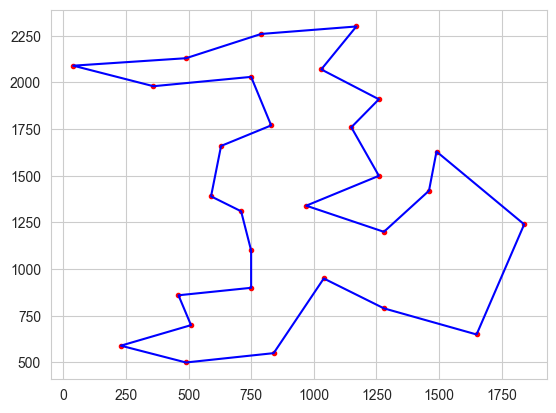

In [72]:
plot_data(optimal_solution)

## Solution Representation
When solving the TSP, the cities are typically represented by numbers from $0$ to $n-1$, and possible solutions will be sequences of these numbers. A problem with five cities, for example, can have solutions of the form $[0,1,2,3,4], [2,4,3,1,0]$, and so on. Each solution can be evaluated by calculating and totaling the distances between each two subsequent cities, then adding the distance between the last city to the first one. Consequently, when applying the problem using the genetic algorithms approach, we can use a similar list of integers to serve as the chromosome.

In [73]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [74]:
POPULATION_SIZE = 1800
MAX_GENERATIONS = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
HALL_OF_FAME_SIZE = 30

In [98]:
toolbox = base.Toolbox()

We want to minimize the distance, which translates to a single-objective minimizing `Fitness` class, defined using a single negative weight.

In [99]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

The `Individual` class is created first, extending an awway of integers and augmenting it with the `FitnessMin` class.

In [100]:
creator.create("Individual", array, typecode='i', fitness=creator.FitnessMin)

The `random_order` operator is then registered to provide the results of the `random.sample()` invocation over a range defined by the lenght of the TSP problem (the number of cities, or $n$). This will result in a randomly generated list of indices between $0$ and $n-1$.

In [101]:
toolbox.register("random_order", random.sample, range(tsp_size), tsp_size)

The `individual_creator` operator is created next. When called, it will, in turn, invoke the `random_order` operator and iterate over the results, to create a valid chromosome consisting of the city indices.

In [102]:
toolbox.register("individual_creator", tools.initIterate, creator.Individual, toolbox.random_order)

The last operator, `population_creator`, is then created to produce a list of individuals using the `individual_creator` operator.

In [103]:
toolbox.register("population_creator", tools.initRepeat, list, toolbox.individual_creator)

Once the chromosome was implemented, it is time to define the fitness evaluation function. This is carried out by the `tsp_distance()` function, which directly utilizes the `get_total_distance()` function.

In [104]:
def tps_distance(individual) -> tuple:
    return get_total_distance(individual),
toolbox.register("evaluate", tps_distance)

Next, we need to define the genetic operators. For the selection operator, we can use tournament selection with a tournament size of 3.

In [105]:
toolbox.register("select", tools.selTournament, tournsize=3)

However, before picking the crossover and mutation operators, we need to remember that the chromosome we use is not just a list of integers, but a list of indices that represent the order of the cities, and therefore we cannot just mix parts of two lists together, or arbitrarily change an index in the list. Instead, we need to use specialized operators that were designed to produce valid lists of indices.

In [106]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/tsp_size)

Create initial population (generation 0).

In [107]:
population = toolbox.population_creator(n=POPULATION_SIZE)
print("Population size: %s" % (len(population)))
print("Individual size: %s" % (len(population[0])))
print("Individual sample: %s" % (population[0]))

Population size: 1800
Individual size: 29
Individual sample: Individual('i', [15, 16, 0, 18, 6, 2, 20, 14, 24, 10, 21, 7, 27, 1, 12, 13, 3, 23, 5, 22, 4, 11, 17, 25, 28, 9, 26, 19, 8])


In [108]:
generation_counter = 0

In [109]:
fitness_values = list(map(toolbox.evaluate, population))
print("Fitness value of one individual: %s" % (fitness_values[0]))

Fitness value of one individual: 25539.965


In [110]:
for individual, fitness_value in zip(population, fitness_values):
    individual.fitness.values = fitness_value

In [111]:
fitness_values = [individual.fitness.values[0] for individual in population]
print("Fitness value of one individual: %s" % (fitness_values[0]))

Fitness value of one individual: 25539.965


Define the hall of fame.

In [112]:
hall_of_fame = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [113]:
hall_of_fame.update(population)
hof_size = len(hall_of_fame.items) if hall_of_fame.items else 0

In [114]:
min_fitness_values = list()
mean_fitness_values = list()

# Genetic Algorithm (GA)

In [115]:
execution_times = []
individuals_sizeof = [getsizeof(ind) for ind in population]
population_sizeof = sum(individuals_sizeof)
best_fitness = float('inf')
first_gen_best = None

while generation_counter < MAX_GENERATIONS:
    start_gen = time()
    generation_counter += 1

    # selection
    offspring = toolbox.select(population, len(population) - hof_size)
    offspring = list(map(toolbox.clone, offspring))

    # crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < P_CROSSOVER:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # mutation
    for mutant in offspring:
        if random.random() < P_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # evaluate fresh individuals
    fresh_individuals = [individual for individual in offspring if not individual.fitness.valid]
    fresh_fitness_values = list(map(toolbox.evaluate, fresh_individuals))
    for individual, fitness_value in zip(fresh_individuals, fresh_fitness_values):
        individual.fitness.values = fitness_value

    # add the best back to population:
    offspring.extend(hall_of_fame.items)

    # Update the hall of fame with the generated individuals
    hall_of_fame.update(offspring)

    # replace population
    population[:] = offspring

    # gather statistics
    fitness_values = [individual.fitness.values[0] for individual in population]
    min_fitness = min(fitness_values)
    mean_fitness = sum(fitness_values) / len(fitness_values)
    min_fitness_values.append(min_fitness)
    mean_fitness_values.append(mean_fitness)
    best_index = fitness_values.index(min(fitness_values))

    # First generation which has the best fitness
    current_best_fitness = min(ind.fitness.values[0] for ind in population)
    if current_best_fitness < best_fitness:
        best_fitness = current_best_fitness
        first_gen_best = generation_counter

    end_gen = time()-start_gen
    execution_times.append(end_gen)
    print(f"\nGeneration {generation_counter}: exec time (s) {end_gen:.4f}, max fitness {min_fitness:.4f}, mean fitness {mean_fitness:.4f}")
    print("Best individual = %s" % (population[best_index]))


Generation 1: exec time (s) 0.0350, max fitness 19872.2305, mean fitness 25132.4102
Best individual = Individual('i', [24, 17, 13, 26, 14, 22, 4, 25, 1, 5, 8, 11, 7, 20, 27, 15, 3, 9, 19, 21, 16, 12, 0, 23, 10, 6, 28, 2, 18])

Generation 2: exec time (s) 0.0540, max fitness 18508.1855, mean fitness 24081.8652
Best individual = Individual('i', [4, 2, 19, 1, 5, 8, 18, 26, 15, 9, 28, 16, 3, 17, 24, 6, 27, 23, 12, 14, 21, 10, 13, 22, 7, 0, 25, 20, 11])

Generation 3: exec time (s) 0.0273, max fitness 17751.0703, mean fitness 23340.4980
Best individual = Individual('i', [0, 7, 5, 20, 8, 28, 24, 23, 26, 12, 9, 6, 22, 19, 14, 16, 17, 18, 15, 27, 11, 4, 25, 2, 1, 13, 3, 21, 10])

Generation 4: exec time (s) 0.0239, max fitness 17500.5508, mean fitness 22594.3203
Best individual = Individual('i', [23, 27, 5, 19, 28, 25, 10, 17, 4, 11, 8, 2, 20, 9, 1, 16, 21, 3, 6, 13, 14, 18, 15, 12, 24, 22, 0, 7, 26])

Generation 5: exec time (s) 0.0205, max fitness 16513.8867, mean fitness 21920.6816
Best in

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

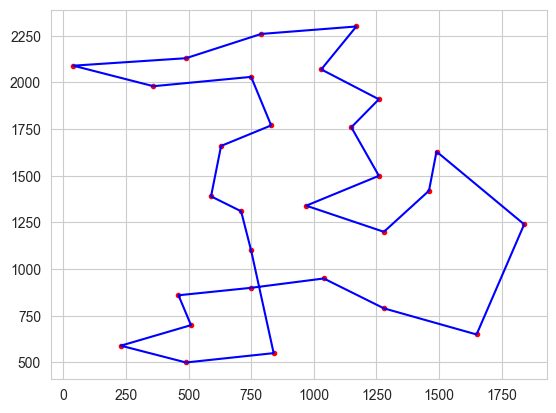

In [116]:
plot_data(population[best_index])

╒══════════════╤═════════════════════════════╤═══════════════╤═══════════════╤═══════════════╤═════════════════╤══════════════════════╕
│   Population │   Population sizeof (Bytes) │   Generetions │   Min Fitness │   Avg Fitness │   Exec Time (s) │   Avg Exec Times (s) │
╞══════════════╪═════════════════════════════╪═══════════════╪═══════════════╪═══════════════╪═════════════════╪══════════════════════╡
│         1800 │                      381600 │           300 │       9278.53 │       9467.66 │         6.26243 │            0.0208748 │
╘══════════════╧═════════════════════════════╧═══════════════╧═══════════════╧═══════════════╧═════════════════╧══════════════════════╛


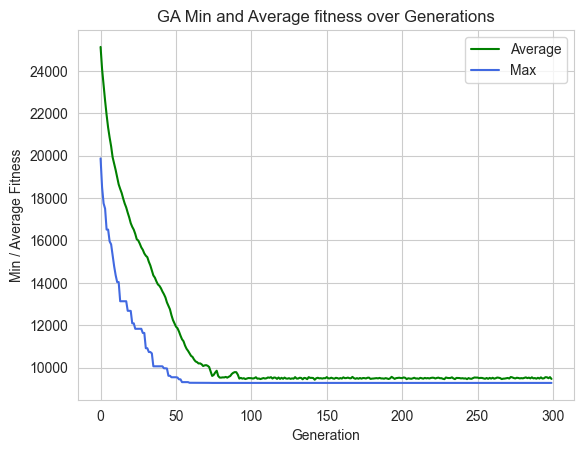

In [117]:
# visualize statistics
table = [['Population', 'Population sizeof (Bytes)', 'Generetions', 'Min Fitness', 'Avg Fitness', 'Exec Time (s)', 'Avg Exec Times (s)'], 
         [POPULATION_SIZE, population_sizeof, MAX_GENERATIONS, min_fitness_values[-1], mean_fitness_values[-1], np.sum(execution_times), np.mean(execution_times)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

sns.set_style("whitegrid")
plt.plot(mean_fitness_values, color='green', label='Average')
plt.plot(min_fitness_values, color='royalblue', label='Max')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('GA Min and Average fitness over Generations')
plt.legend()
plt.show()

As we found a good solution but not the best-known one, we can try and figure out ways to improve the results. For example, we can experiment with channging the population size, number of generations, and the probabilities. We can also replace the genetic operators with other compatible ones. We can even change the random seed we set just to see the effect on the results, or make multiple runs with different seeds.

# Artificial Bee Colony (ABC) algorithm

In [38]:
def neighborhood(ind):
    """Generate a neighbor solution by swapping two random indices in the individual."""
    a, b = random.sample(range(len(ind)), 2)
    neighbor = ind[:]
    neighbor[a], neighbor[b] = neighbor[b], neighbor[a]
    return neighbor

def artificial_bee_colony(fitness_evaluator, pop_size: int, max_cycles: int, limit: int) -> tuple[list, float, list, list, int, list, int]:
    """ Artificial Bee Colony algorithm for TSP problem.
    Args:
        fitness_evaluator: A function that evaluates the fitness of an individual.
        pop_size: The number of artificial bees in the population.
        max_cycles: Number of iterations to run the algorithm.
        limit: The number of cycles a bee can go without finding a better solution before becoming a scout.
    Returns:
        tuple: best solution, best fitness, history of best fitness, history of mean fitness, total population size in bytes, execution times, first iteration min fitness. 

    """
    def f_min(bee):
        return fitness_evaluator(bee)[0]
        
    # Each bee holds a solution and a trial counter
    bees = [toolbox.individual_creator() for _ in range(pop_size)]
    fitness = [f_min(bee) for bee in bees]
    trials = [0]*pop_size
    bees_sizeof = [getsizeof(bee) for bee in bees]
    
    best = min(zip(bees, fitness), key=lambda x: x[1])
    best_history = []
    mean_history = []
    execution_times = []
    first_iter_min_fitness = None

    print("Iterations:")
    for cycle in range(max_cycles):
        start_time = time()
        # Employed bees phase
        for i in range(pop_size):
            neigh = neighborhood(bees[i])
            fit = f_min(neigh)
            if fit < fitness[i]:
                bees[i], fitness[i], trials[i] = neigh, fit, 0
                if fit < best[1]:
                    best = (neigh, fit)
                    first_iter_min_fitness = cycle
            else:
                trials[i] += 1

        # Calculate selection probabilities for onlookers
        max_fit = max(fitness)
        probs = [ (max_fit - f + 1e-6) for f in fitness ]
        probs = [p/sum(probs) for p in probs]

        # Onlooker bees phase
        for _ in range(pop_size):
            i = random.choices(range(pop_size), probs)[0]
            neigh = neighborhood(bees[i])
            fit = f_min(neigh)
            if fit < fitness[i]:
                bees[i], fitness[i], trials[i] = neigh, fit, 0
                if fit < best[1]:
                    best = (neigh, fit)
            else:
                trials[i] += 1

        # Scout bees phase
        for i in range(pop_size):
            if trials[i] > limit:
                bees[i] = toolbox.individual_creator()
                fitness[i] = f_min(bees[i])
                trials[i] = 0

        end_time = time()-start_time
        execution_times.append(end_time)
        best_history.append(best[1])
        mean_history.append(np.mean(fitness))
        print(f"{cycle} - Best fitness: {best[1]} - Avg Fitness: {np.mean(fitness):.4f} - Exec Time: {end_time:.4f}s")

    population_sizeof = sum(bees_sizeof)
    return best[0], best[1], best_history, mean_history, population_sizeof, execution_times, first_iter_min_fitness

In [39]:
abc_population = POPULATION_SIZE
abc_iterations = MAX_GENERATIONS
trials_limit = 300
abc_sol, abc_val, abc_best_history, abc_mean_history, abc_population_sizeof, abc_execution_times, abc_first_iter_min_fitness = artificial_bee_colony(tps_distance, pop_size=abc_population, max_cycles=abc_iterations, limit=trials_limit)
print("\nABC Best Solution", abc_sol)
#abc_sol, abc_val, abc_hist = artificial_bee_colony(tps_distance, pop_size=POPULATION_SIZE*4, max_cycles=MAX_GENERATIONS*3, limit=200)

Iterations:
0 - Best fitness: 19198.427734375 - Avg Fitness: 25784.1816 - Exec Time: 0.2308s
1 - Best fitness: 18759.55859375 - Avg Fitness: 25190.6973 - Exec Time: 0.2231s
2 - Best fitness: 18258.25390625 - Avg Fitness: 24642.3203 - Exec Time: 0.2184s
3 - Best fitness: 18156.537109375 - Avg Fitness: 24156.5098 - Exec Time: 0.2193s
4 - Best fitness: 16882.326171875 - Avg Fitness: 23713.9062 - Exec Time: 0.2210s
5 - Best fitness: 16882.326171875 - Avg Fitness: 23309.7520 - Exec Time: 0.2185s
6 - Best fitness: 16882.326171875 - Avg Fitness: 22939.3262 - Exec Time: 0.2173s
7 - Best fitness: 15934.353515625 - Avg Fitness: 22574.4961 - Exec Time: 0.2190s
8 - Best fitness: 15934.353515625 - Avg Fitness: 22254.6465 - Exec Time: 0.2411s
9 - Best fitness: 15588.1904296875 - Avg Fitness: 21963.3828 - Exec Time: 0.2208s
10 - Best fitness: 15500.126953125 - Avg Fitness: 21691.8262 - Exec Time: 0.2196s
11 - Best fitness: 15053.31640625 - Avg Fitness: 21439.4375 - Exec Time: 0.2188s
12 - Best fitnes

╒══════════════╤═════════════════════════════╤══════════════╤════════════════╤═══════════════╤═══════════════╤═════════════════╤══════════════════════╕
│   Population │   Population sizeof (Bytes) │   Iterations │   Trials Limit │   Min Fitness │   Avg Fitness │   Exec Time (s) │   Avg Exec Times (s) │
╞══════════════╪═════════════════════════════╪══════════════╪════════════════╪═══════════════╪═══════════════╪═════════════════╪══════════════════════╡
│         1800 │                      381600 │          300 │            300 │       9661.58 │       12674.3 │         68.8649 │              0.22955 │
╘══════════════╧═════════════════════════════╧══════════════╧════════════════╧═══════════════╧═══════════════╧═════════════════╧══════════════════════╛


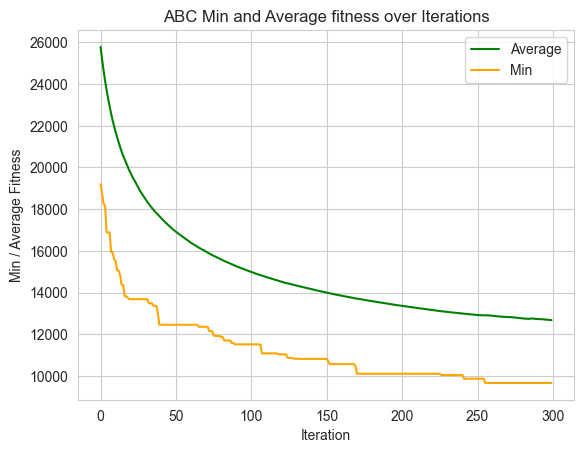

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

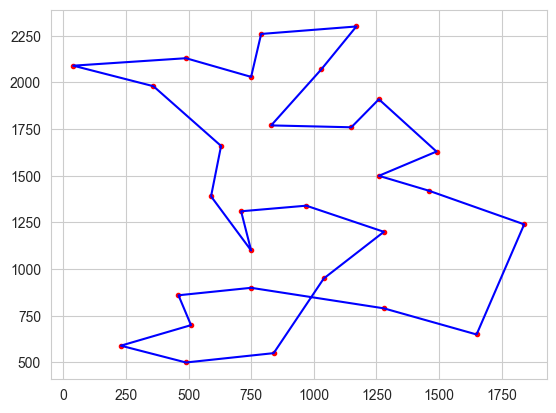

In [40]:
table = [['Population', 'Population sizeof (Bytes)', 'Iterations', 'Trials Limit', 'Min Fitness', 'Avg Fitness', 'Exec Time (s)', 'Avg Exec Times (s)'], 
         [abc_population, abc_population_sizeof, abc_iterations, trials_limit, abc_best_history[-1], abc_mean_history[-1], np.sum(abc_execution_times), np.mean(abc_execution_times)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
sns.set_style("whitegrid")
plt.plot(abc_mean_history, color='green', label='Average')
plt.plot(abc_best_history, color='orange', label='Min')
plt.xlabel('Iteration')
plt.ylabel('Min / Average Fitness')
plt.title('ABC Min and Average fitness over Iterations')
plt.legend()
plt.show()
plot_data(abc_sol)

# Ant Colony Optimization (ACO) algorithm

In [53]:
def ant_colony_optimization(num_cities: int, distances: np.array, fitness_evaluator, pop_size: int, max_cycles: int, alpha=1.0, beta=2.0, rho=0.3, Q=100.0) -> tuple[list, float, list, list, int, list, int]:
    """ Ant Colony Optimization for TSP problem.
    Args:
        num_cities (int): Number of cities.
        distances (np.array): Distance matrix between cities.
        fitness_evaluator: Function to evaluate the fitness of a solution.
        pop_size (int): Number of artificial ants to generate.
        max_cycles (int): Number of iterations to run the algorithm.
        alpha (float): Influence of the pheromone level (tau) in selecting the next graph node (≥ 0).
        beta (float): Influence of the influence of the cost (eta) for selecting the next graph node (≥ 0).
        rho (float): Pheromone evaporation rate (between 0 and 1).
        Q (float): Pheromone deposit constant.
    Returns:
        tuple: best solution, best fitness, history of best fitness, history of mean fitness, total population size in bytes, execution times, first iteration min fitness. 

    """
    # Initial pheromone level τ matrix
    tau = np.ones((num_cities, num_cities))
    # Initial heuristic information η matrix (1/distance)     
    eta = 1.0 / (distances + 1e-10) # Avoid division by zero by adding a small constant
    np.fill_diagonal(eta, 0.0)

    best_solution = None
    best_value = float('inf') # (+) for minimization; (-) for maximizing
    best_history = []
    mean_history = []
    ants_sizeof = []

    for cycle in range(max_cycles):
        start_time = time()
        all_solutions = []
        all_fitness = []
        
        # Each ant constructs a tour by visiting cities based on pheromone and heuristic information
        for ant in range(pop_size):
            ants_sizeof.append(getsizeof(ant))
            unvisited = set(range(num_cities))
            current = random.choice(list(unvisited))
            tour = [current]
            unvisited.remove(current)
            # Calculating the cities attractiveness and probabilities over nodes
            while unvisited:
                probs = []
                for j in unvisited:
                    probs.append((tau[current, j]**alpha) * (eta[current, j]**beta))
                probs = np.array(probs)
                probs = probs / probs.sum()  # Normalize probabilities

                next_city = random.choices(list(unvisited), weights=probs, k=1)[0]
                tour.append(next_city)
                unvisited.remove(next_city)
                current = next_city

            tour_length = fitness_evaluator(tour)[0]
            all_solutions.append(tour)
            all_fitness.append(tour_length)

            # Update best solution
            if tour_length < best_value:
                best_value = tour_length
                best_solution = tour.copy()
                first_iter_min_fitness = cycle

        # Evaporate
        tau *= (1 - rho)

        # Deposit pheromone over each edge in the tours
        for tour, tour_length in zip(all_solutions, all_fitness):
            deposit = Q / (1 + tour_length)
            for i in range(num_cities):
                a = tour[i]
                b = tour[(i+1) % num_cities]
                tau[a, b] += deposit
                tau[b, a] += deposit

        end_time = time()-start_time
        execution_times.append(end_time)
        best_history.append(best_value)
        mean_history.append(np.mean(all_fitness))
        print(f"{cycle} - Best fitness: {best_value} - Avg Fitness: {np.mean(all_fitness):.4f} - Exec Time: {end_time:.4f}s")
    
    population_sizeof = sum(ants_sizeof)
    return best_solution, best_value, best_history, mean_history, population_sizeof, execution_times, first_iter_min_fitness

In [54]:
aco_population = POPULATION_SIZE
aco_iterations = MAX_GENERATIONS
aco_sol, aco_val, aco_best_history, aco_mean_history, aco_population_sizeof, aco_execution_times, aco_first_iter_min_fitness = ant_colony_optimization(tsp_size, np.array(distances), tps_distance, pop_size=aco_population, max_cycles=aco_iterations)
print("\nACO best solution:", aco_sol)

0 - Best fitness: 12599.244140625 - Avg Fitness: 17525.0684 - Exec Time: 0.4964s
1 - Best fitness: 10923.646484375 - Avg Fitness: 14732.4980 - Exec Time: 0.4484s
2 - Best fitness: 9913.5400390625 - Avg Fitness: 13705.0664 - Exec Time: 0.4462s
3 - Best fitness: 9713.048828125 - Avg Fitness: 13170.8242 - Exec Time: 0.4466s
4 - Best fitness: 9601.84375 - Avg Fitness: 12829.7168 - Exec Time: 0.4460s
5 - Best fitness: 9596.5556640625 - Avg Fitness: 12552.6094 - Exec Time: 0.4555s
6 - Best fitness: 9519.1396484375 - Avg Fitness: 12404.7520 - Exec Time: 0.4936s
7 - Best fitness: 9519.1396484375 - Avg Fitness: 12316.3760 - Exec Time: 0.4513s
8 - Best fitness: 9298.12890625 - Avg Fitness: 12229.3711 - Exec Time: 0.4472s
9 - Best fitness: 9297.6337890625 - Avg Fitness: 12180.6709 - Exec Time: 0.4457s
10 - Best fitness: 9297.6337890625 - Avg Fitness: 12125.1758 - Exec Time: 0.4464s
11 - Best fitness: 9297.6337890625 - Avg Fitness: 12118.0635 - Exec Time: 0.4507s
12 - Best fitness: 9266.6943359375

╒══════════════╤═════════════════════════════╤══════════════╤═══════════════╤═══════════════╤═════════════════╤══════════════════════╕
│   Population │   Population sizeof (Bytes) │   Iterations │   Min Fitness │   Avg Fitness │   Exec Time (s) │   Avg Exec Times (s) │
╞══════════════╪═════════════════════════════╪══════════════╪═══════════════╪═══════════════╪═════════════════╪══════════════════════╡
│         1800 │                    15120000 │          300 │       9074.15 │         11897 │         1324.19 │             0.441396 │
╘══════════════╧═════════════════════════════╧══════════════╧═══════════════╧═══════════════╧═════════════════╧══════════════════════╛


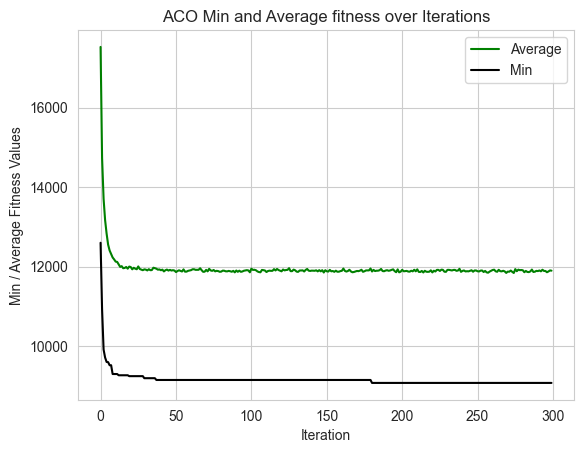

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

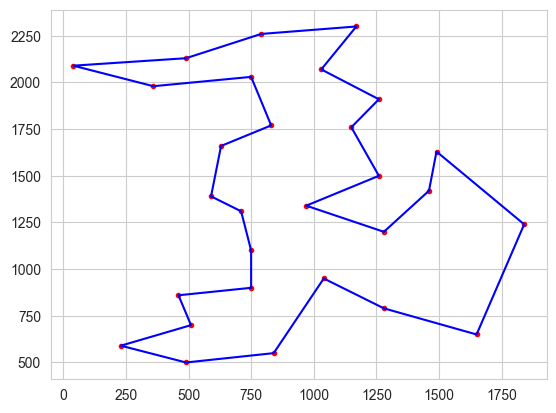

In [55]:
table = [['Population', 'Population sizeof (Bytes)', 'Iterations', 'Min Fitness', 'Avg Fitness', 'Exec Time (s)', 'Avg Exec Times (s)'], 
         [aco_population, aco_population_sizeof, aco_iterations, aco_best_history[-1], aco_mean_history[-1], np.sum(aco_execution_times), np.mean(aco_execution_times)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
sns.set_style("whitegrid")
plt.plot(aco_mean_history, color='green', label='Average')
plt.plot(aco_best_history, color='black', label='Min')
plt.xlabel('Iteration')
plt.ylabel('Min / Average Fitness Values')
plt.title('ACO Min and Average fitness over Iterations')
plt.legend()
plt.show()
plot_data(aco_sol)

# GA vs ACO vs ABC

Comparing Genetic Algorithm, Ant Colony Optimization, and Artificial Bee Colony
╒═════════════╤═══════╤════════╤═══════════════╤═══════════════╤════════════════════════════════════════════╤═════════════════╕
│ Algorithm   │   Pop │   Iter │   Min Fitness │   Avg Fitness │   N° iter which achieved first min fitness │   Exec Time (s) │
╞═════════════╪═══════╪════════╪═══════════════╪═══════════════╪════════════════════════════════════════════╪═════════════════╡
│ GA          │  1800 │    300 │       9278.53 │       9467.66 │                                         79 │         6.26243 │
├─────────────┼───────┼────────┼───────────────┼───────────────┼────────────────────────────────────────────┼─────────────────┤
│ ACO         │  1800 │    300 │       9074.15 │      11897    │                                        180 │      1324.19    │
├─────────────┼───────┼────────┼───────────────┼───────────────┼────────────────────────────────────────────┼─────────────────┤
│ ABC         │  1800 │ 

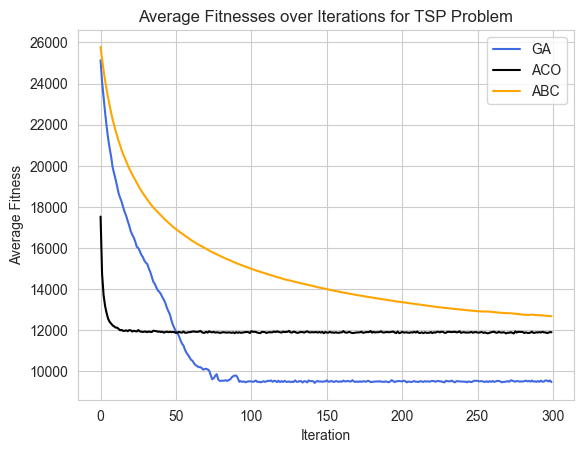

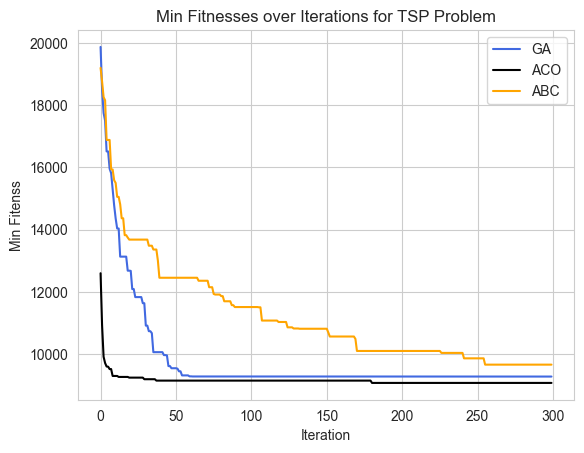

In [118]:
print("Comparing Genetic Algorithm, Ant Colony Optimization, and Artificial Bee Colony")

table = [['Algorithm', 'Pop', 'Iter', 'Min Fitness', 'Avg Fitness', 'N° iter which achieved first min fitness', 'Exec Time (s)'], 
         ['GA', POPULATION_SIZE, MAX_GENERATIONS, min_fitness_values[-1], mean_fitness_values[-1], first_gen_best, np.sum(execution_times)],
         ['ACO', aco_population, aco_iterations, aco_best_history[-1], aco_mean_history[-1], aco_first_iter_min_fitness, np.sum(aco_execution_times)],
         ['ABC', abc_population, abc_iterations, abc_best_history[-1], abc_mean_history[-1], abc_first_iter_min_fitness, np.sum(abc_execution_times)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

sns.set_style("whitegrid")
plt.plot(mean_fitness_values, color='royalblue', label='GA')
plt.plot(aco_mean_history, color='black', label='ACO')
plt.plot(abc_mean_history, color='orange', label='ABC')
plt.xlabel('Iteration')
plt.ylabel('Average Fitness')
plt.title('Average Fitnesses over Iterations for TSP Problem')
plt.legend()
plt.show()

sns.set_style("whitegrid")
plt.plot(min_fitness_values, color='royalblue', label='GA')
plt.plot(aco_best_history, color='black', label='ACO')
plt.plot(abc_best_history, color='orange', label='ABC')
plt.xlabel('Iteration')
plt.ylabel('Min Fitenss')
plt.title('Min Fitnesses over Iterations for TSP Problem')
plt.legend()
plt.show()